In [1]:
from jax import random as jr, lax, nn
from pymdp.jax.envs import GraphEnv
from pymdp.jax.agent import Agent
from typing import Sequence, Optional

import mctx
import networkx as nx
import jax.numpy as jnp
import chex
import pygraphviz

from IPython.display import SVG

In [2]:
def convert_tree_to_graph(
    tree: mctx.Tree,
    action_labels: Optional[Sequence[str]] = None,
    batch_index: int = 0
) -> pygraphviz.AGraph:
  """Converts a search tree into a Graphviz graph.

  Args:
    tree: A `Tree` containing a batch of search data.
    action_labels: Optional labels for edges, defaults to the action index.
    batch_index: Index of the batch element to plot.

  Returns:
    A Graphviz graph representation of `tree`.
  """
  chex.assert_rank(tree.node_values, 2)
  batch_size = tree.node_values.shape[0]
  if action_labels is None:
    action_labels = range(tree.num_actions)
  elif len(action_labels) != tree.num_actions:
    raise ValueError(
        f"action_labels {action_labels} has the wrong number of actions "
        f"({len(action_labels)}). "
        f"Expecting {tree.num_actions}.")

  def node_to_str(node_i, reward=0, discount=1):
    return (f"{node_i}\n"
            f"Reward: {reward:.2f}\n"
            f"Discount: {discount:.2f}\n"
            f"Value: {tree.node_values[batch_index, node_i]:.2f}\n"
            f"Visits: {tree.node_visits[batch_index, node_i]}\n")

  def edge_to_str(node_i, a_i):
    node_index = jnp.full([batch_size], node_i)
    probs = nn.softmax(tree.children_prior_logits[batch_index, node_i])
    return (f"{action_labels[a_i]}\n"
            f"Q: {tree.qvalues(node_index)[batch_index, a_i]:.2f}\n"  # pytype: disable=unsupported-operands  # always-use-return-annotations
            f"p: {probs[a_i]:.2f}\n")

  graph = pygraphviz.AGraph(directed=True)

  # Add root
  graph.add_node(0, label=node_to_str(node_i=0), color="green")
  # Add all other nodes and connect them up.
  for node_i in range(tree.num_simulations):
    for a_i in range(tree.num_actions):
      # Index of children, or -1 if not expanded
      children_i = tree.children_index[batch_index, node_i, a_i]
      if children_i >= 0:
        graph.add_node(
            children_i,
            label=node_to_str(
                node_i=children_i,
                reward=tree.children_rewards[batch_index, node_i, a_i],
                discount=tree.children_discounts[batch_index, node_i, a_i]),
            color="red")
        graph.add_edge(node_i, children_i, label=edge_to_str(node_i, a_i))

  return graph

In [3]:
def generate_connected_clusters(cluster_size=2, connections=2):
    edges = []
    connecting_node = 0
    while connecting_node < connections * cluster_size:
        edges += [(connecting_node, a) for a in range(connecting_node + 1, connecting_node + cluster_size + 1)]
        connecting_node = len(edges)
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph, {
        "locations": [
            (f"hallway {i}" if len(list(graph.neighbors(loc))) > 1 else f"room {i}")
            for i, loc in enumerate(graph.nodes)
        ]
    }

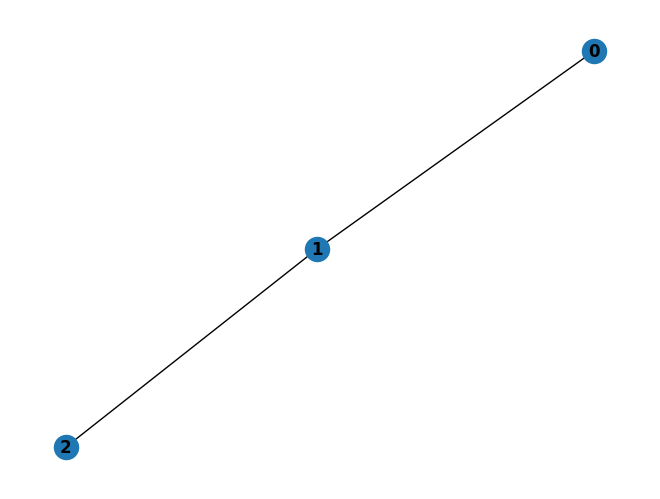

In [4]:
graph, _ = generate_connected_clusters(cluster_size=1, connections=2)
nx.draw(graph, with_labels=True, font_weight="bold")

In [5]:
key = jr.PRNGKey(0)
object_location = 2
agent_location = 0
env = GraphEnv(graph, object_location, agent_location)

2024-06-12 20:52:10.635152: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
A = [a for a in env.params["A"]]
B = [b for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[:, 1].set(1.0)

D = [jnp.ones(b.shape[:2]) / b.shape[1] for b in B]
D[0] = env.params['D'][0]
D[1] = env.params['D'][1] * (1 - nn.one_hot(0, env.params['D'][1].shape[-1]))

batch_size = A[0].shape[0]

agent = Agent(
    A,
    B,
    C,
    D,
    None,
    None,
    None,
    A_dependencies=A_dependencies,
    B_dependencies=B_dependencies,
    onehot_obs=False
)

In [7]:
import mctx
from tmp_mcts import make_aif_recurrent_fn

recurrent_fn = make_aif_recurrent_fn()
action = jnp.zeros(1, dtype=jnp.int8)
print(recurrent_fn(agent, key, action, agent.D))

rng_key = jr.PRNGKey(111)

(RecurrentFnOutput(reward=Array([0.], dtype=float32), discount=Array([1.], dtype=float32), prior_logits=Array([[-1.0986123, -1.0986123, -1.0986123]], dtype=float32), value=Array([0.], dtype=float32)), [Array([[1.000000e+00, 4.930361e-32, 0.000000e+00]], dtype=float32), Array([[4.9303610e-32, 2.2204415e-16, 1.0000000e+00, 2.2204415e-16]],      dtype=float32)])


[[0.00246652 0.995067   0.00246652]]


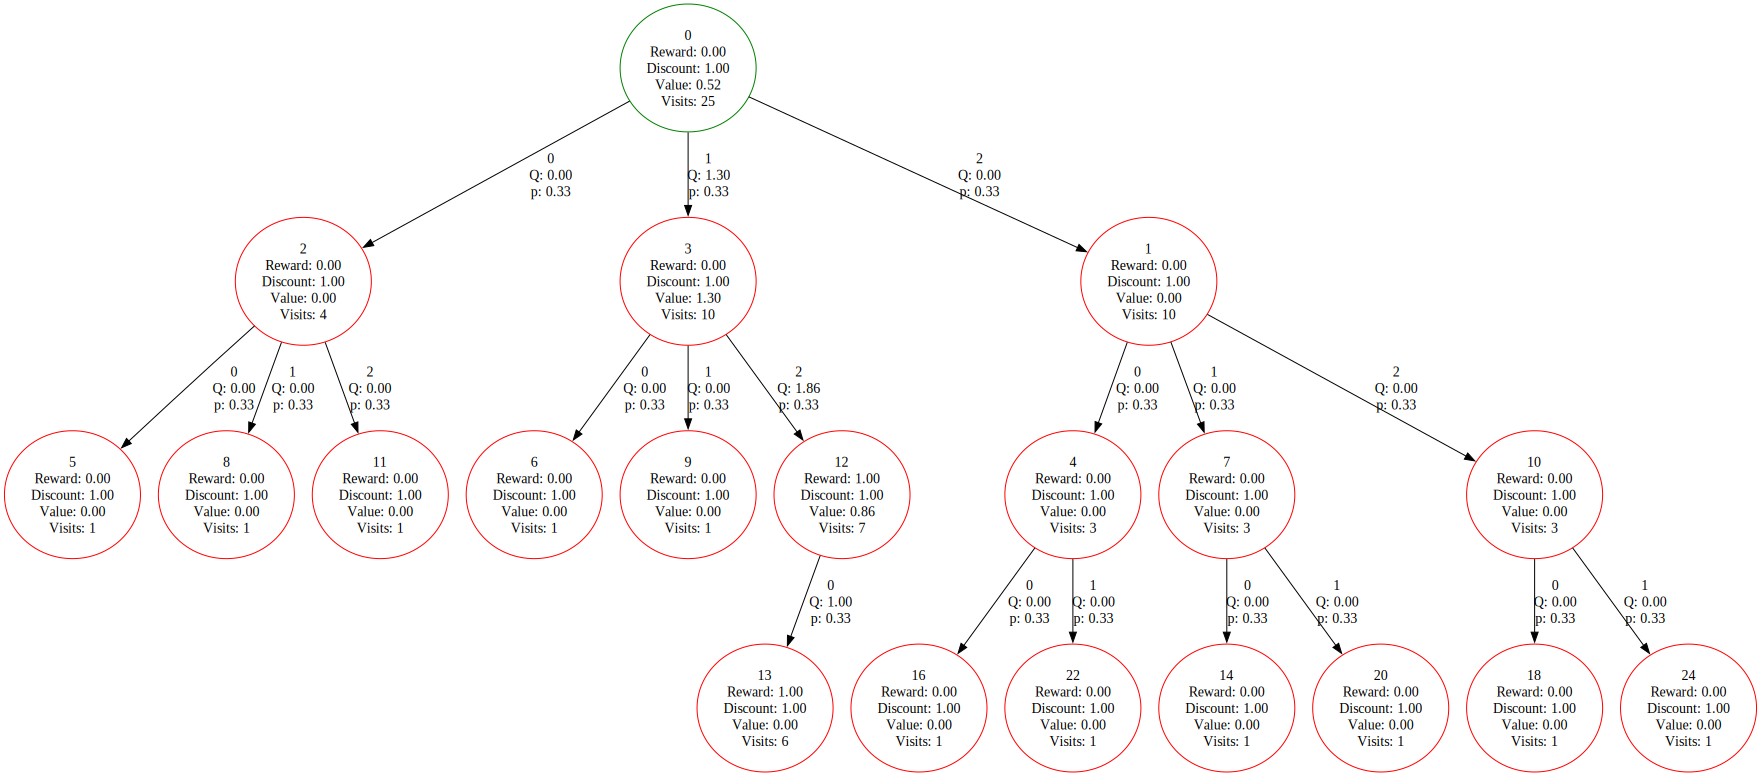

In [18]:
# %%timeit
root = mctx.RootFnOutput(
    prior_logits=jnp.log(agent.E),
    value=jnp.zeros((batch_size)),
    embedding=agent.D,
)

policy_output = mctx.gumbel_muzero_policy(
    agent,
    rng_key,
    root,
    recurrent_fn,
    num_simulations=32,
    max_depth=3
)

tree_gumbel = policy_output.search_tree
print(policy_output.action_weights)

graph = convert_tree_to_graph(tree_gumbel)
svg = graph.draw(format='svg', prog='dot').decode(graph.encoding)
SVG(svg)

[[0.0625 0.8125 0.125 ]]


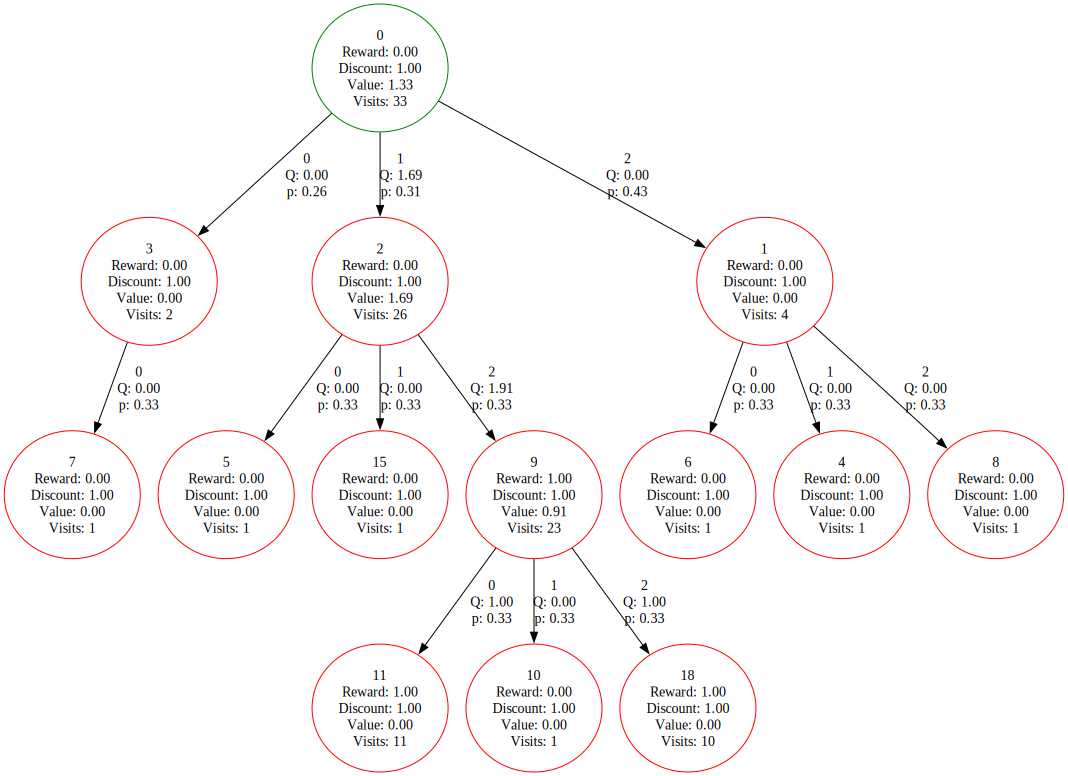

In [19]:
# %%timeit
root = mctx.RootFnOutput(
    prior_logits=jnp.log(agent.E),
    value=jnp.zeros((batch_size)),
    embedding=agent.D,
)

policy_output = mctx.muzero_policy(
    agent,
    rng_key,
    root,
    recurrent_fn=recurrent_fn,
    num_simulations=32,
    max_depth=3
)

tree = policy_output.search_tree
print(policy_output.action_weights)

graph = convert_tree_to_graph(tree)
svg = graph.draw(format='svg', prog='dot').decode(graph.encoding)
SVG(svg)

In [10]:
root = mctx.RootFnOutput(
    prior_logits=jnp.log(agent.E),
    value=jnp.zeros((batch_size)),
    embedding=agent.D,
)

n_pi = len(agent.policies)

mctx.stochastic_muzero_policy(
    agent,
    rng_key,
    root,
    num_simulations=512,
    max_depth=3
)

TypeError: stochastic_muzero_policy() missing 2 required positional arguments: 'decision_recurrent_fn' and 'chance_recurrent_fn'